# Andel af Hospitaliseringer (non age corrected)

Find en forskydning mellem hospitaliseringer og antal positive på en dag, ved at analysere peaket omkring jul. Antal dage imellem peaket svarer altså til det antal dage der går fra du konstanteres smittes til en andel indlægges. Andelen findes til sidst ved antal hospitaliseringer (for forskydningen af dage frem) divideret med antal positive for dagen. Antallet af positive som bliver indlagt forventes umiddelbart at være konstant, dog er vi begyndt at vaccinere så langsomt bør vi kunne begynde at se andelen blive mindre.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

In [2]:
mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")

# Indlæs data

In [3]:
folder = 'overvaagningsdata-covid19-26042021-ga29'

data_døde = pd.read_csv(folder + "/Deaths_over_time.csv", sep=';', thousands='.', index_col=0)
data_hospital = pd.read_csv(folder + "/Newly_admitted_over_time.csv", sep=';', thousands='.', index_col=0)
data_posi = pd.read_csv(folder + "/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)

fit_to_latest = True

# Print how much data is included:
date_start = "2020-08-31"
if fit_to_latest :
    date_end = data_hospital.index[-3]  # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-04-26"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    

# Hospitalisations per day
H_all = data_hospital.loc[date_start:date_end]['Total']
eH_all = np.sqrt(H_all)

# Deaths per day
D_all = data_døde.loc[date_start:date_end]['Antal_døde']
eD_all = np.sqrt(D_all)

# Number of positives per days
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)

# Array with times
Plot_startday = 0
Plot_endday = len(H_all)
days = np.arange(Plot_startday, Plot_endday)

  Data used:  2020-08-31 - 2021-04-23


# Forskydning mellem hosp. og positive

Text(0, 0.5, 'Antal positive')

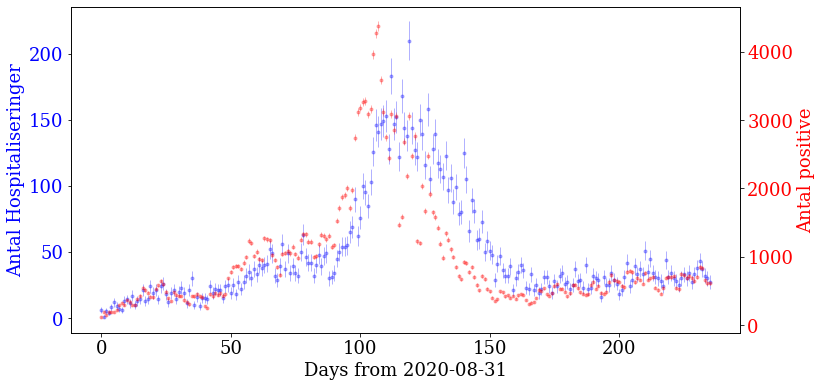

In [4]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal Hospitaliseringer', color='blue')
ax2.set_ylabel('Antal positive', color='red')

In [5]:
# Fit med en gauss på en lineær baggrund?

# Definer fit funktion
def gauss_plus_lin(x, N, mu, sigma, a, b):
    
    gauss = N * stats.norm.pdf(x, mu, sigma)
    
    lin = a*x + b
    
    return gauss + lin

# Definer chi2 udreging
def chi2_H(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((H_all - y_fit) / eH_all)**2 )

    return chi2

def chi2_P(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((P_all - y_fit) / eP_all)**2 )

    return chi2

# Fit the hospitalisations
minuit_H = Minuit(chi2_H, N=np.sum(H_all), mu=110, sigma=15, a=-2, b=50, print_level=1, errordef=1.0)
minuit_H.migrad(); 

# Fit the positives
minuit_P = Minuit(chi2_P, N=np.sum(P_all), mu=105, sigma=5, a=-2, b=70, print_level=1, errordef=1.0)
minuit_P.migrad(); 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 794                        │        Nfcn = 419 (419 total)        │
│ EDM = 6.74e-07 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.84e+04                   │        Nfcn = 175 (175 total)        │
│ EDM = 8.23e-06 (Goal: 0.0002)    │                                      │
├───────────

Text(0, 0.5, 'Antal positive')

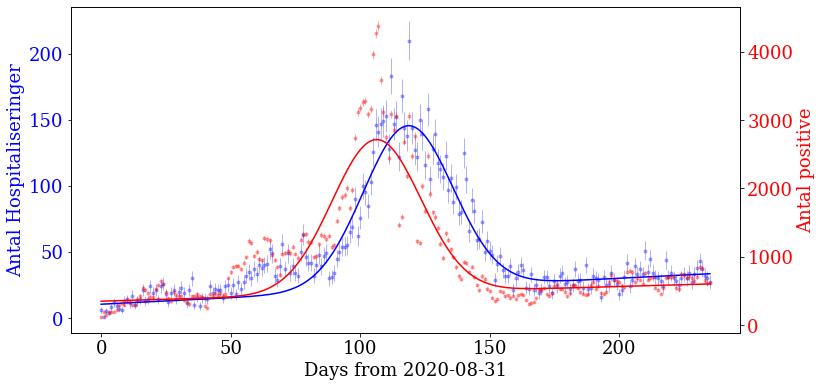

In [6]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Hospitalisations plot
ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Hospitalisations fit
ax1.plot(days, gauss_plus_lin(days, *minuit_H.args), color='blue')

# Positives plot
ax2 = ax1.twinx() 
ax2.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

# Positives fit
ax2.plot(days, gauss_plus_lin(days, *minuit_P.args), color='red')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal Hospitaliseringer', color='blue')
ax2.set_ylabel('Antal positive', color='red')

In [7]:
# What is the shift between the two peaks
H_shift = minuit_H.values['mu'] - minuit_P.values['mu']
eH_shift = minuit_H.errors['mu'] + minuit_P.errors['mu']
print(f'{ H_shift } +/- {eH_shift}' )

12.258939152808708 +/- 0.39607043821875804


# Plot døde og hospitaliseringer - find forskydning ved at fitte gauss

Text(0, 0.5, 'Antal døde')

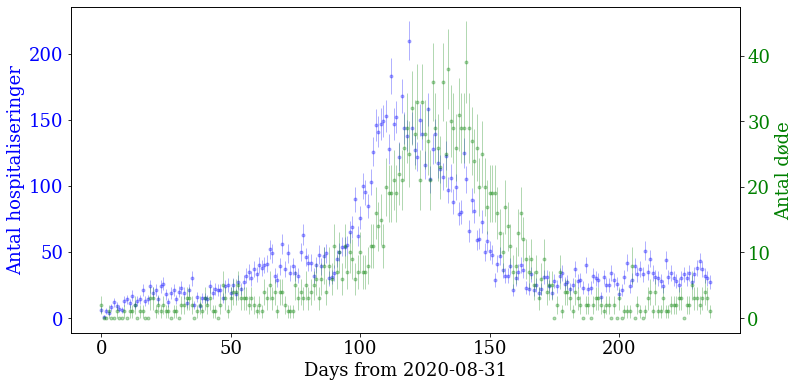

In [8]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.errorbar(days, D_all, yerr=eD_all, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal hospitaliseringer', color='blue')
ax2.set_ylabel('Antal døde', color='green')

In [9]:
# Fit med en gauss på en lineær baggrund?

# Definer chi2 udreging for døde
def chi2_D(N, mu, sigma, a, b):
    
    y_fit = gauss_plus_lin(days, N, mu, sigma, a, b)
    chi2 = np.sum( ((D_all - y_fit) / eD_all)**2 )

    return chi2

# Fit the hospitalisations
minuit_H = Minuit(chi2_H, N=np.sum(H_all), mu=110, sigma=15, a=0.1, b=50, print_level=1, errordef=1.0)
minuit_H.migrad(); 

# Fit the positives
minuit_D = Minuit(chi2_D, N=np.sum(D_all), mu=130, sigma=20, a=0, b=0, print_level=1, errordef=1.0)
minuit_D.migrad();

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 794                        │        Nfcn = 137 (137 total)        │
│ EDM = 0.000163 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = inf                        │        Nfcn = 123 (123 total)        │
│ EDM = nan (Goal: 0.0002)         │                                      │
├───────────

Text(0, 0.5, 'Antal døde')

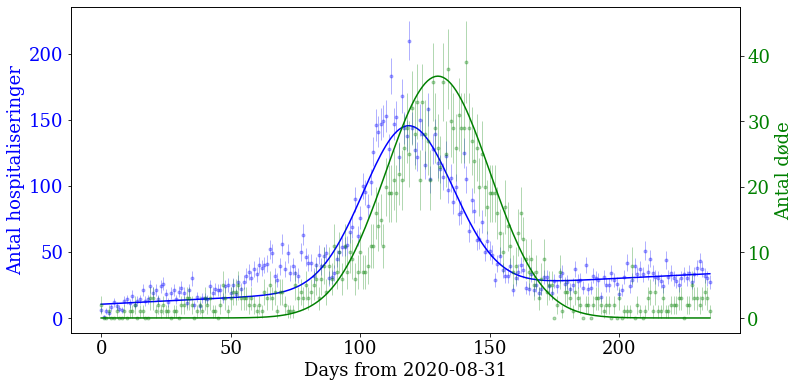

In [10]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Hospitalisations plot
ax1.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Hospitalisations fit
ax1.plot(days, gauss_plus_lin(days, *minuit_H.args), color='blue')

# Deaths plot
ax2 = ax1.twinx() 
ax2.errorbar(days, D_all, yerr=eD_all, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='green')

# Positives fit
ax2.plot(days, gauss_plus_lin(days, *minuit_D.args), color='green')

ax1.set_xlabel(f'Days from {date_start}')
ax1.set_ylabel('Antal hospitaliseringer', color='blue')
ax2.set_ylabel('Antal døde', color='green')

In [11]:
# What is the shift between the two peaks
D_shift = minuit_D.values['mu'] - minuit_H.values['mu']
eD_shift = minuit_D.errors['mu'] + minuit_H.errors['mu']
print(f'{ D_shift } +/- {eD_shift}' )

11.480428408824324 +/- nan


# Different graphs showing SP, Hospitalisations and Deaths

## Plot 1: Positives, Hospitaliseringer og Døde (DAILY)

Text(0.5, 0, 'Days from 2020-08-31')

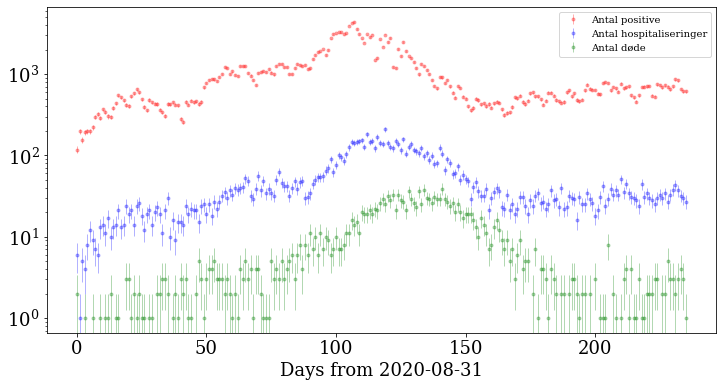

In [12]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot raw data 
ax.errorbar(days, P_all, yerr=eP_all, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax.errorbar(days, H_all, yerr=eH_all, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax.errorbar(days, D_all, yerr=eD_all, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start}')

Her kan vi se at hvert peak er forskudt fra de andre, først smittes man, nogen hospitaliseres 12 dage senere i gennemsnit og 11 dage efter det i gennemsnit er der nogen der dør.

Der er nok noget upålideligt ved errors på de døde (den grønne graf) da statistikken er så lav at poisson errors ikke fungerer optimalt. Det kan vi gøre bedre ved at kigge på det weekly istedet for daily, først skal vi dog allignes dem.

## Plot 2: Alligned plot med Scaled positives, hospitaliseringer og døde (DAILY)

In [13]:
#Vi skal bruge forskydningerne
print('Hospitaliserings forskydning fra SP:', H_shift, '+/-', eH_shift)
print('Døde forskydning fra hospitaliseringer:', D_shift, '+/-', eD_shift)

Hospitaliserings forskydning fra SP: 12.258939152808708 +/- 0.39607043821875804
Døde forskydning fra hospitaliseringer: 11.480428408824324 +/- nan


In [14]:
# Vi skal bruge en diskret værdi
H_sh = int(np.round(H_shift))
D_sh = int(np.round(D_shift))

# total shift
tot_sh = H_sh + D_sh

print(H_sh, D_sh)

12 11


In [15]:
# Lad os nu lave vores alligned array, det betyder at vi må skære 12+11 datapunkter fra hver ende.
P_alligned = P_all.iloc[:-tot_sh] #iloc for at bruge index nummer
eP_alligned = eP_all.iloc[:-tot_sh]

H_alligned = H_all.iloc[H_sh:-D_sh]
eH_alligned = eH_all.iloc[H_sh:-D_sh]

D_alligned = D_all.iloc[tot_sh:]
eD_alligned = eD_all.iloc[tot_sh:]

days_alligned = days[:-tot_sh]

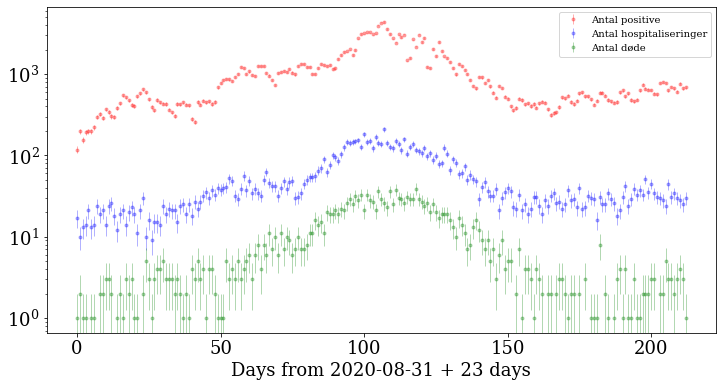

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot alligned data 
ax.errorbar(days_alligned, P_alligned, yerr=eP_alligned, fmt='.', linewidth=1, label='Antal positive', color='red', alpha=0.3)
ax.errorbar(days_alligned, H_alligned, yerr=eH_alligned, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue', alpha=0.3)
ax.errorbar(days_alligned, D_alligned, yerr=eD_alligned, fmt='.', linewidth=1, label='Antal døde', color='green', alpha=0.3)

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')

plt.show()

## Plot 3: Ratio plot (DAILY)

Vi vil plotte fra de alligned arrays: hospitaliseringer/positives, døde/positives og døde/hospitaliseringer.

In [17]:
# First lets get the ratios as arrays
H_by_P = [i/j for i,j in zip(H_alligned, P_alligned)]
D_by_P = [i/j for i,j in zip(D_alligned, P_alligned)]
D_by_H = [i/j for i,j in zip(D_alligned, H_alligned)]

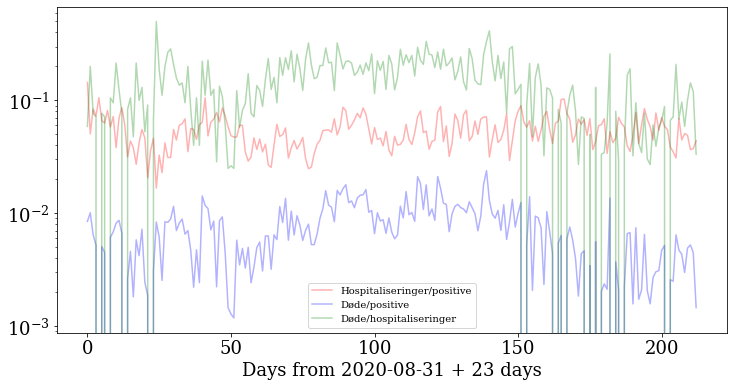

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot ratios 
ax.plot(days_alligned, H_by_P, label='Hospitaliseringer/positive', color='red', alpha=0.3)
ax.plot(days_alligned, D_by_P, label='Døde/positive', color='blue', alpha=0.3)
ax.plot(days_alligned, D_by_H, label='Døde/hospitaliseringer', color='green', alpha=0.3)

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')

plt.show()

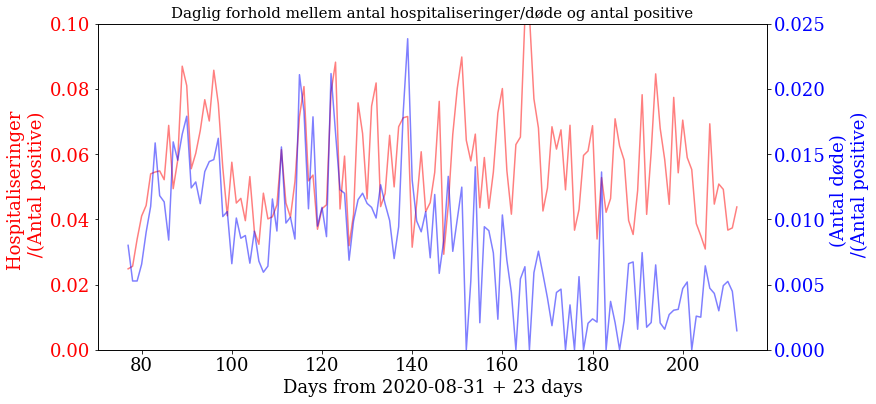

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot ratios 
ax.plot(days_alligned[77:], H_by_P[77:], label='Hospitaliseringer/positive', color='red', alpha=0.5)
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer \n /(Antal positive)', color='red')
ax.set_ylim(0,0.1)

ax2 = ax.twinx() 
ax2.plot(days_alligned[77:], D_by_P[77:], label='Døde/positive', color='blue', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) \n /(Antal positive)', color='blue')
ax2.set_ylim(0,0.025)

#ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')
ax.set_title('Daglig forhold mellem antal hospitaliseringer/døde og antal positive', size=15)
plt.show()

this one, men som twin axis lineær skala og weekly!!! og dato på skrå

## Plot 2: Scaled Positives, Hospitaliseringer og Døde (Weekly)

Vi lader antal positive bestemme hvordan vi inddeler ugerne dvs vi først aligner dem og så inddeler dem efter det. Jeg har valgt den 31 august da dette er en mandag, vi kan da lave et nyt array som indeholder de summede tal for en uge af gangen.

In [20]:
# Find ugentlige data (de er alle alligned)
index = np.arange(0, len(P_alligned)//7 * 7 + 1, 7)

P_weekly = []
eP_weekly = []

H_weekly = []
eH_weekly = []

D_weekly = []
eD_weekly = []

for i in index:
    P_temp = np.sum(P_alligned.iloc[i:i+7])
    H_temp = np.sum(H_alligned.iloc[i:i+7])
    D_temp = np.sum(D_alligned.iloc[i:i+7])
    
    eP_temp = np.sqrt(P_temp)
    eH_temp = np.sqrt(H_temp)
    eD_temp = np.sqrt(D_temp)
    
    P_weekly.append(P_temp)
    eP_weekly.append(eP_temp)
    
    H_weekly.append(H_temp)
    eH_weekly.append(eH_temp)
    
    D_weekly.append(D_temp)
    eD_weekly.append(eD_temp)
    
weeks = np.arange(0, len(P_weekly))

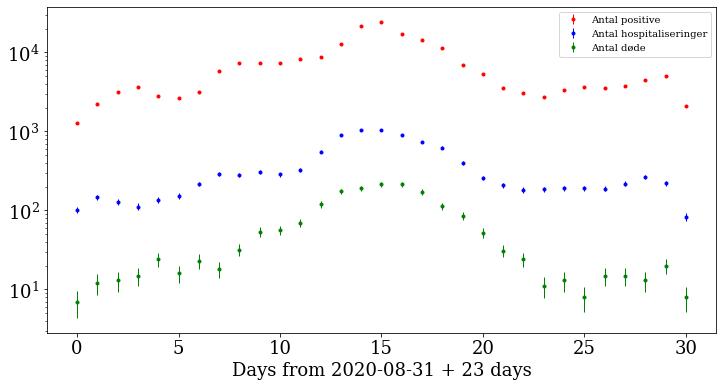

In [21]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot alligned data weekly
ax.errorbar(weeks, P_weekly, yerr=eP_weekly, fmt='.', linewidth=1, label='Antal positive', color='red')
ax.errorbar(weeks, H_weekly, yerr=eH_weekly, fmt='.', linewidth=1, label='Antal hospitaliseringer', color='blue')
ax.errorbar(weeks, D_weekly, yerr=eD_weekly, fmt='.', linewidth=1, label='Antal døde', color='green')

ax.set_yscale('log')
ax.legend(prop={'size': 10})
ax.set_xlabel(f'Days from {date_start} + {tot_sh} days')

plt.show()

## Plot 3: ratio plot (WEEKLY)

In [22]:
# First lets get the ratios as arrays
H_by_P_weekly = [i/j for i,j in zip(H_weekly, P_weekly)]
D_by_P_weekly = [i/j for i,j in zip(D_weekly, P_weekly)]
D_by_H_weekly = [i/j for i,j in zip(D_weekly, H_weekly)]

# Errors on the ratios
def ratio_err(f, x, ex, y, ey): #helper function for error propagation of ratio
    ef = f * np.sqrt( (ex/x)**2 + (ey/y)**2 )
    return ef

eH_by_P_weekly = [ratio_err(H_by_P_weekly[i], H_weekly[i], eH_weekly[i], P_weekly[i], eP_weekly[i]) for i in range(len(P_weekly))]
eD_by_P_weekly = [ratio_err(D_by_P_weekly[i], D_weekly[i], eD_weekly[i], P_weekly[i], eP_weekly[i]) for i in range(len(P_weekly))]
eD_by_H_weekly = [ratio_err(D_by_H_weekly[i], D_weekly[i], eD_weekly[i], H_weekly[i], eH_weekly[i]) for i in range(len(P_weekly))]

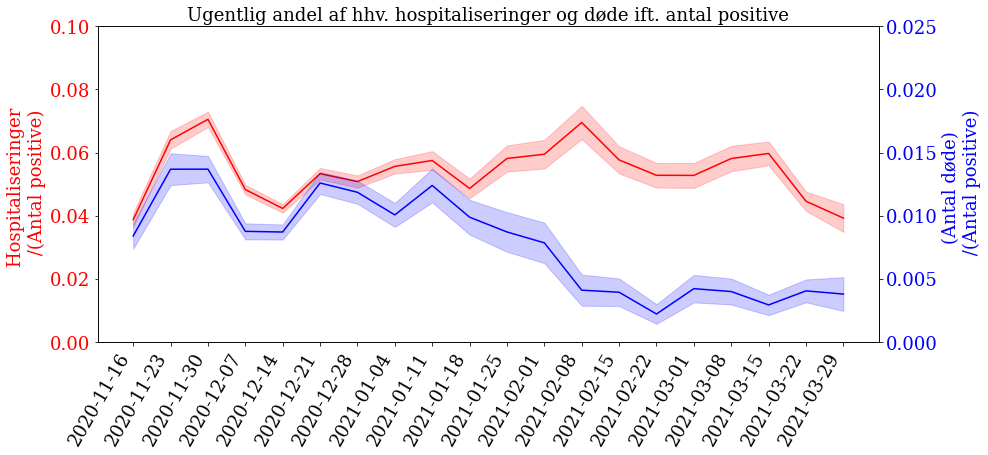

In [23]:
fig, ax = plt.subplots(figsize=(14,6))

# Plot H/P ratio
ax.plot(weeks[11:], H_by_P_weekly[11:], label='Hospitaliseringer/positive', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer \n /(Antal positive)', color='red')
ax.set_ylim(0,0.1)

#mark errors
HP_low = [i-j for i,j in zip(H_by_P_weekly[11:], eH_by_P_weekly[11:])]
HP_high = [i+j for i,j in zip(H_by_P_weekly[11:], eH_by_P_weekly[11:])]
ax.fill_between(x=weeks[11:], y1=HP_low, y2=HP_high, color='red', alpha=0.2)


# Plot D/P on separate axis
ax2 = ax.twinx() 
ax2.plot(weeks[11:], D_by_P_weekly[11:], label='Døde/positive', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) \n /(Antal positive)', color='blue')
ax2.set_ylim(0,0.025)

#mark errors
DP_low = [i-j for i,j in zip(D_by_P_weekly[11:], eD_by_P_weekly[11:])]
DP_high = [i+j for i,j in zip(D_by_P_weekly[11:], eD_by_P_weekly[11:])]
ax2.fill_between(x=weeks[11:], y1=DP_low, y2=DP_high, color='blue', alpha=0.2)


# Make nice xticks showing the week day ---------------------------------------

mon_dates = P_alligned.iloc[0:-1:7].index # get the dates of each monday of the week for entire period
ax.set_xticks( [*weeks[11:]] ) # Set locations
ax.set_xticklabels( mon_dates[11:], rotation=60, rotation_mode='default', ha='right') #, rotation=40 ) # set labels

# ------------------------------------------------------------------------------

ax.set_title('Ugentlig andel af hhv. hospitaliseringer og døde ift. antal positive', size=18)
plt.subplots_adjust(bottom=0.15)
plt.show()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 215.9                      │         Nfcn = 11 (11 total)         │
│ EDM = 8.96e-18 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 54.07                      │        Nfcn = 357 (357 total)        │
│ EDM = 5.94e-08 (Goal: 0.0002)    │                                      │
├───────────

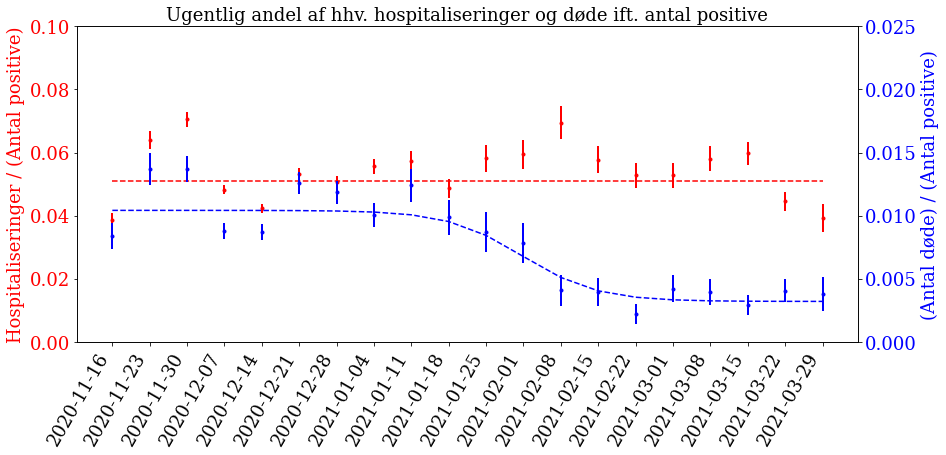

In [24]:
fig, ax = plt.subplots(figsize=(14,6))

# Plot H/P ratio
ax.errorbar(weeks[11:], H_by_P_weekly[11:], yerr=eH_by_P_weekly[11:], fmt='.', linewidth=2, label='Hospitaliseringer/positive', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer / (Antal positive)', color='red')
ax.set_ylim(0,0.1)

# Plot D/P on separate axis
ax2 = ax.twinx() 
ax2.errorbar(weeks[11:], D_by_P_weekly[11:], yerr=eD_by_P_weekly[11:], fmt='.', linewidth=2, label='Døde/positive', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) / (Antal positive)', color='blue')
ax2.set_ylim(0,0.025)

# Fitting a straight line thorugh hospitalisation data ---------------------------
def constant_fit(x, k):
    return np.ones_like(x) * k

def chi2_straight(k):
    y_fit = constant_fit(weeks[11:], k)
    chi2 = np.sum( ((H_by_P_weekly[11:] - y_fit)/eH_by_P_weekly[11:])**2 )
    return chi2

minuit_straight = Minuit(chi2_straight, k=0.06, print_level=1, errordef=1.0)
minuit_straight.migrad(); 

ax.plot(weeks[11:], constant_fit(weeks[11:], *minuit_straight.args), color='red', linestyle='dashed')
# ------------------------------------------------------------------------------

# fitting a sigmoid to deaths ---------------------------------------------
def sigmoid_fit(x, A, B, C):
    return A / (1 + 1*np.exp(-(x-B))) + C

def chi2_sigmoid(A, B, C):
    y_fit = sigmoid_fit(weeks[11:], A, B, C)
    chi2 = np.sum( ((D_by_P_weekly[11:] - y_fit)/eD_by_P_weekly[11:])**2 )
    return chi2

minuit_sigmoid = Minuit(chi2_sigmoid, A=-0.2, B=22, C=0.02, print_level=1, errordef=1.0)
minuit_sigmoid.migrad(); 

ax2.plot(weeks[11:], sigmoid_fit(weeks[11:], *minuit_sigmoid.args), color='blue', linestyle='dashed')

# ------------------------------------------------------------------------------

# Make nice xticks showing the week day ---------------------------------------
mon_dates = P_alligned.iloc[0:-1:7].index # get the dates of each monday of the week for entire period
ax.set_xticks( [*weeks[11:]] ) # Set locations
ax.set_xticklabels( mon_dates[11:], rotation=60, rotation_mode='default', ha='right') # set labels

# ------------------------------------------------------------------------------

# marker ferier -----------------------------------


ax.set_title('Ugentlig andel af hhv. hospitaliseringer og døde ift. antal positive', size=18)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Vacciner

Først skal vi have delt data for vacciner op i risikogrupper. Vi skelner ikke mellem mænd og kvinder, og vi bruger ikke data fra SSI filen men fra denne graf. Denne er opdateret fra 14. april
https://www.sst.dk/-/media/Udgivelser/2021/Corona/Vaccination/Kalender/Specificeret-vaccinationskalender-14042021.ashx?la=da&hash=F6757A03252C95723C73F71025F9BA9BCC91E2FB

Vi ser på hver risikogruppe. Der er et tidsinterval hvor vaccinationerne administreres, vi antager at de fordeles uniformt i tid. Dermed kan vi få N(t) for denne periode, hvor N beskriver antallet af personer som har fået det første skud vaccine.

Hver gruppe skal også have tildelt en risiko. Dertil bruger vi følgende graf fra USA:
https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html
som vejlende. Der er dog risikogrupper som ikke er bestemt pr. alder så her må vi komme med et bud. Bemærk at det er relativ risiko der er vigtig, så hvor den placerer sig på y aksen er irelevant - vi vil dog gerne have at den kan ses på grafen ovenfor med ratios.

Sikkerhedes for vaccinen estimeres et sted mellem 85 og 95 procent for både første og andet skud patienter - vi vælger den derfor til 90%.

Det vi skal plotte er:
$$ \sum N(t) \cdot Risiko \cdot (1-\epsilon_{vac}) $$

Hov det giver vidst ikke mening for det vil stige da N(t) bliver større, som flere vaccineres - det er nok nærmere:
<br> Relativ risiko for død = Risiko for ikke vacc. + Risiko for vacc.

$$ \sum (Total N - N(t)\cdot \epsilon_{vac}) \cdot Risiko $$

$$+ \sum N(t) \cdot Risiko \cdot (1-\epsilon_{vac}) $$



In [26]:
# Total antal af mennesker i hver gruppe #tilføj en score med risiko gange antal!
tot1 = 43456
tot2 = 60063
tot3 = 97602
tot4 = 442518
tot5 = 224455
tot6 = 6000
tot7 = 128087
tot8 = 227609
tot9 = 534023
tot10a = 282219
tot10b = 339550
tot10c = 327669
tot10d1 = 593122
tot10d2 = 621547
tot10d3 = 633312
tot10d4 = 323728

# samlet liste
tot_arr = [tot1,tot2,tot3,tot4,tot5,tot6,tot7,tot8,tot9,tot10a,tot10b,tot10c,tot10d1,tot10d2,tot10d3,tot10d4] 
print(np.sum(tot_arr))

4884960


Det passer vidst med dem der mangler er folk under 16 år.


De første vaccinationer starter i uge 53, det vil sige d. 28 december. Der er altså 6 uger i den viste periode (fra 16 november) hvor ingen er vaccineres. Det bliver lidt svært at lave N(t) arrays for hver gruppe så lad os definere en hjælper funktion som laver disse arrays. Den skal vide hvor mange uger ingen i gruppen vaccineres målt fra d 6. november. For den første gruppe vil det være 6. Derudover skal den vide total antal mennersker i gruppen, det har vi defineret ovenfor. Så skal den kende hvor lang perioden der vaccineres denne gruppe er, samt hvor lang perioden vi vil vise i plottet er i alt - her er der tale om 20 uger.

In [27]:
def N_arr_maker(weeks_in, total_N, vacc_weeks, weeks_in_period = 20):
    
    # Weeks with no vaccinated
    N_arr = np.zeros(weeks_in)
    
    # Find number of people vaccinated pr week in the period
    vaccinated_pr_week = total_N / vacc_weeks
    
    # Append the newly vaccinated, and make sure it is cumulative
    N_arr = np.append(N_arr, np.arange(1, vacc_weeks+1)*vaccinated_pr_week )
    
    # The last weeks where all in the group is vaccinated N(t) is constant if within period
    if weeks_in_period > (weeks_in + vacc_weeks):
        missing_weeks = weeks_in_period - len(N_arr)
        N_arr = np.append(N_arr, np.ones(missing_weeks)*N_arr[-1])
        
    if weeks_in_period < (weeks_in + vacc_weeks):
        N_arr = N_arr[:weeks_in_period]
    
    return N_arr

Vi definere hvor mange uger hver gruppes vaccinationer administreres over. Bemærk at gruppe 4 er mærkelig og er delt op i to perioder. For nu har jeg bare sat dem sammen.

In [28]:
# Define how many weeks each vaccination group takes to all get vaccinated, all in one list
vacc_weeks_arr = [7, 11, 7, 11, 14, 14, 7, 6, 9, 7, 7, 7, 8, 7, 7, 7]

# Define how many weeks in the vaccination starts for each group
weeks_in_arr = [6, 7, 11, 6, 7, 7, 17, 19, 20, 24, 25, 26, 27, 29, 30, 31]

# Lets create the arrays #plot histogram over uger med antal personer
N_arr = []
for i in range(len(tot_arr)):
    N_arr.append(N_arr_maker(weeks_in_arr[i], tot_arr[i], vacc_weeks_arr[i]))

Nu har vi vores N(t) arrays men mangler at definere risikoen. Her estimerer vi en del, og jeg gætter så kvalificeret som muligt ud fra cdc dataet.

In [44]:
#risk_arr = [10000, 9000, 8700, 100, 8000, 100, 3200, 3200, 1300, 800, 600, 440, 50, 50, 30, 45]
risk_arr = np.array([100000, 75000, 50000, 100, 20000, 100, 5000, 3200, 1300, 800, 600, 440, 50, 50, 30, 45])

# CDC score plus ny vector med en faktor der accounter for omstændigheder?


eff = 0.9 #efficiency of vaccine

In [45]:
# Lets make the calculation
death_risk_arr = np.array([])

for i in range(20):

    Ns_now = np.array([])

    for j in range(len(N_arr)):
        
        N_temp = N_arr[j][i]
        
        Ns_now = np.append(Ns_now, N_temp)
        
    death_risk_now = np.sum( (tot_arr - Ns_now) * risk_arr) + np.sum( Ns_now * risk_arr * (1-eff) ) #change
    
    death_risk_arr = np.append(death_risk_arr, death_risk_now)

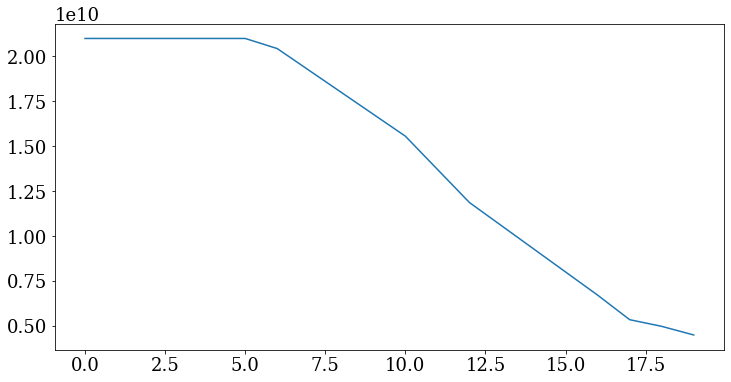

In [46]:
# Plot it
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(np.arange(20), death_risk_arr ) #normliser så den går fra 1 til 0

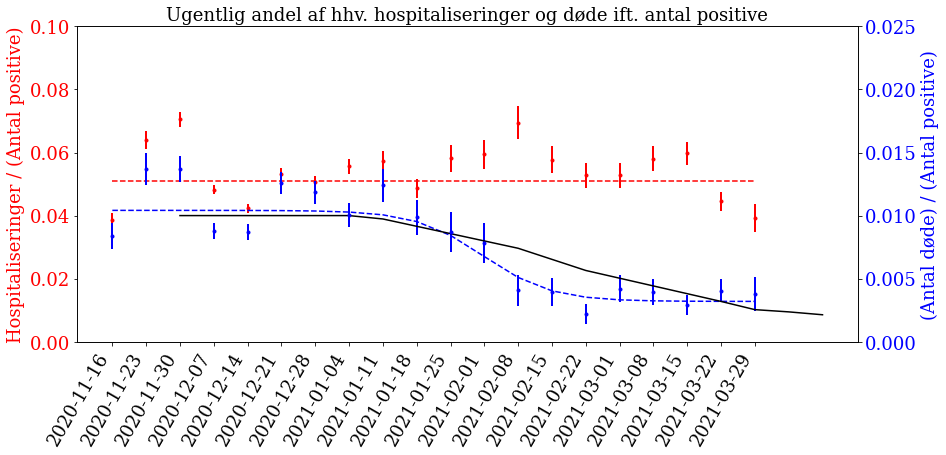

In [48]:
fig, ax = plt.subplots(figsize=(14,6))

# Plot H/P ratio
ax.errorbar(weeks[11:], H_by_P_weekly[11:], yerr=eH_by_P_weekly[11:], fmt='.', linewidth=2, label='Hospitaliseringer/positive', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_ylabel('Hospitaliseringer / (Antal positive)', color='red')
ax.set_ylim(0,0.1)

# Plot D/P on separate axis
ax2 = ax.twinx() 
ax2.errorbar(weeks[11:], D_by_P_weekly[11:], yerr=eD_by_P_weekly[11:], fmt='.', linewidth=2, label='Døde/positive', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('(Antal døde) / (Antal positive)', color='blue')
ax2.set_ylim(0,0.025)
ax.plot(weeks[11:], constant_fit(weeks[11:], *minuit_straight.args), color='red', linestyle='dashed')
ax2.plot(weeks[11:], sigmoid_fit(weeks[11:], *minuit_sigmoid.args), color='blue', linestyle='dashed')

# Make nice xticks showing the week day ---------------------------------------
mon_dates = P_alligned.iloc[0:-1:7].index # get the dates of each monday of the week for entire period
ax.set_xticks( [*weeks[11:]] ) # Set locations
ax.set_xticklabels( mon_dates[11:], rotation=60, rotation_mode='default', ha='right') # set labels
# ------------------------------------------------------------------------------


# Mark death risk


ax2.plot(weeks[11:]+2, death_risk_arr/np.sum( tot_arr*risk_arr )*0.01 , color='k')




ax.set_title('Ugentlig andel af hhv. hospitaliseringer og døde ift. antal positive', size=18)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [ ]:
# forskyd med 14 dagei weeks_in i N_arr_maker funktion